### Aplicando método de otimização para ajuste do modelo
### Argentina - Dados de Hospitalização

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler 

In [25]:
#import data
data = pd.read_csv("Datasets/rosario_hosp.csv")  
acc_n_hosp = data.cumulative_hospitalized_patients
normalized_acc_n_hosp = acc_n_hosp / max(acc_n_hosp)
t = np.linspace(0, len(acc_n_hosp), len(acc_n_hosp))

# for the "one wave" tests
model = f_t
n_days = 90 

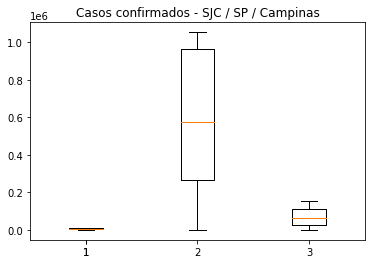

In [26]:
plt.title('Casos confirmados - SJC / SP / Campinas')
plt.boxplot(acc_n_hosp)
data = pd.read_csv("Datasets/sp.csv")  
sp = data.total_confirmed
data = pd.read_csv("Datasets/campinas.csv")  
camp = data.total_confirmed
plt.boxplot([acc_n_hosp, sp, camp])
plt.show()

### 1 - Uma onda epidemiológica

#### 1.1 - Definindo o problema de otimização
Definiremos uma função para descrever a perda do modelo em relação aos dados reais. Ela será a função objetivo do problema de minimização.

Seja o vetor x de parâmetros:
$$x = [A\quad \nu\quad \delta\quad t_p]^T$$
Problema de otimização descrito no artigo da ASOC:
$$min \sum_{t=0}^{t=t_{end}} t(y_t(t) - y_m(t, x))^2$$ 

$$\textrm{s.t.}\quad A \geq 0,\\\quad\quad\ \nu > 0,\\\quad\quad\ \delta > 0,\\\quad\quad\  t_p \geq 0$$ 

Ao invés de utilizarmos a função objetivo apresentada (ITSE), _utilizaremos a Mean Squared Error_ (MSE), que pode ser formulada da seguinte forma:
$$MSE(x) = \sum_{t=0}^{t=t_{end}} (y_t(t) - y_m(t, x))^2$$

A otimização será feita em duas etapas:
- 1 - Otimizar uma sigmoide simétrica ($\nu$ = 1)
- 2 - Otimizar uma sigmoide assimétrica, utilizando o ponto ótimo da etapa 1 como ponto inicial.

Para a implementação, estamos utilizando a função [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
) do pacote do otimização da biblioteca Scipy. O método de otimização utilizado é o _Sequential Least Squares Programming_ (SLSQP).

![](https://i.imgur.com/4goNTaQ.png)

A função em questão também permite a utilização de diversos outros métodos de otimização.

![](https://i.imgur.com/m2hO3lL.png)



In [27]:
n_sig = 1
sig_params = []
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_hosp[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_n_hosp[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta = 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 

/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 460.9204921445169
     jac: array([-1.52587891e-05, -7.85827637e-04, -1.33514404e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 112
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([989.30076584,  56.88082287,  13.80530074,   1.        ])


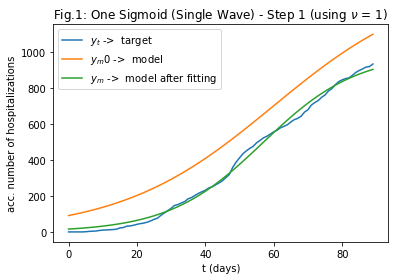

In [28]:
# Step 1 - Optimize a symmetric sigmoid (nu = 1)
y_t = acc_n_hosp[:n_days]
A0 = 1.5*max(y_t)
tp0 = (2/3)*len(y_t)
delta0 = (1/4)*len(y_t)
nu0 = 1
x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.1: One Sigmoid (Single Wave) - Step 1 (using $\\nu$ = 1)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model')
plt.plot(y_m, label='$y_m$ ->  model after fitting')
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.legend()
plt.show()

     fun: 181.51804810403067
     jac: array([-2.09808350e-05,  1.82914734e-03, -1.07192993e-03,  1.59757885e+02])
 message: 'Optimization terminated successfully'
    nfev: 100
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([1.20825312e+03, 5.49178882e+01, 2.60705261e+01, 1.00000000e-01])


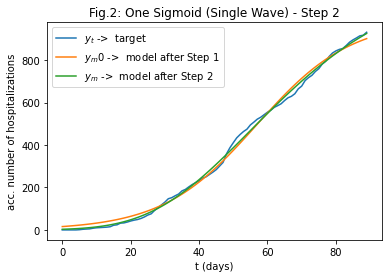

In [29]:
# Step 2 - Optimize an assymmetric sigmoid
# using optimal values of step 1 as the starting point
[A0, tp0, delta0, nu0] = sol.x

x0 = [A0, tp0, delta0, nu0]
sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
print(sol)

# Optimal values
[A, tp, delta, nu] = sol.x

y_t = acc_n_hosp[:n_days]
y_m0 = f_t(t[:n_days], A0, tp0, delta0, nu0)
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('Fig.2: One Sigmoid (Single Wave) - Step 2')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
plt.plot(y_m, label='$y_m$ ->  model after Step 2')
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.legend()
plt.show()

### 2 - Múltiplas ondas epidemiológicas
Para fazer o ajuste do modelo para dados de N ondas epidemiológicas, utilizamos um modelo que envolve a soma de N sigmoides ($f(t)$).

![](https://i.imgur.com/YixfYwH.png)

[Escrever aqui um textinho mais elaborado documentando a lógica para múltiplas ondas]

In [30]:
a = []
a.append([1, 2, 3, 4])
a.append([5, 6, 7, 8])
print(a)
print(a[0])

[[1, 2, 3, 4], [5, 6, 7, 8]]
[1, 2, 3, 4]


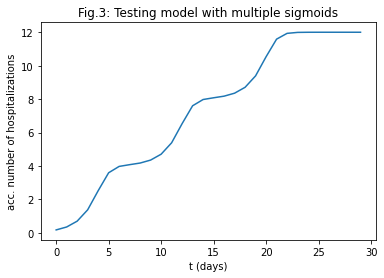

In [31]:
# Testing model for multiple sigmoids
n_days = 30
n_sig = 3
sig_params = [
    [4, 4, 0.5, 2.9],
    [4, 12, 0.5, 2.9]
]
[A, tp, delta, nu] = [4, 20, 0.5, 2.9]
plt.title('Fig.3: Testing model with multiple sigmoids')
plt.plot(model(t[:n_days], A, tp, delta, nu))
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.show()

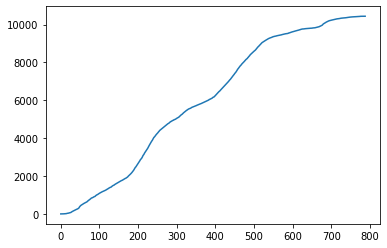

In [32]:
plt.plot(acc_n_hosp)

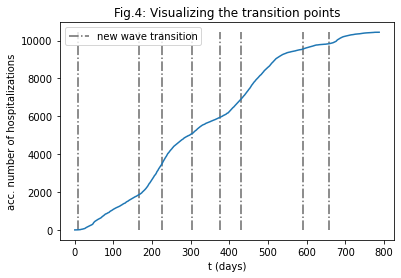

In [42]:
fig = plt.figure()
plt.plot(acc_n_hosp)
# Defini manualmente, por enquanto...
# pelo new_wave.py daria x_t [11, 101, 167, 254] (Jerusalem)
#x_nw = [90, 170, 240] #(Jerusalém)
#x_nw = [147, 287, 382, 669] #(SJC)
#x_nw = [84, 259, 314, 375, 688] # (SP)
#x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
x_nw = [8, 166, 226, 303, 375, 431, 590, 657] # Rosario tr 1e-5
#x_nw = [100, 149, 471, 610, 681, 741] # Camilas tr 3e-5

plt.title('Fig.4: Visualizing the transition points')
plt.vlines(x_nw, 0, max(acc_n_hosp), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.legend()
plt.show()


========= Wave nr 1 =========
From 0 to  8
Step 1
     fun: 0.0026104187887662235
     jac: array([ 0.0001324 , -0.00025003,  0.00011415,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 111
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([4.15244212, 5.55836757, 0.45471386, 1.        ])
Step 2
     fun: 9.757597030686123e-05
     jac: array([-0.00010117, -0.00054612,  0.00101873,  0.00151373])
 message: 'Optimization terminated successfully'
    nfev: 71
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([4.3874481 , 5.33714197, 0.70478471, 0.1       ])


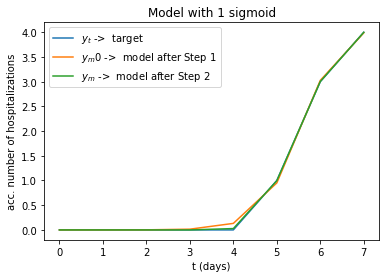

========= Wave nr 2 =========
From 0 to  166
Step 1
     fun: 4335.952448373661
     jac: array([0.00012207, 0.00012207, 0.00012207, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 110
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.83987531e+03, 8.97540486e+01, 2.80829007e+01, 1.00000000e+00])
Step 2
     fun: 1787.10084513625
     jac: array([-5.79833984e-04,  5.81359863e-03,  1.25885010e-02,  2.64567197e+03])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([2.09499707e+03, 8.12621586e+01, 4.81577853e+01, 1.00000000e-01])


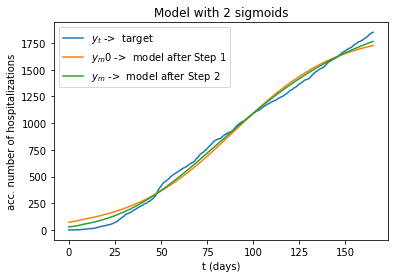

========= Wave nr 3 =========
From 0 to  226
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1292.5885386619116
     jac: array([ 0.00032043, -0.01283264, -0.01400757,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 98
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([1.74800159e+03, 2.04996008e+02, 1.35617574e+01, 1.00000000e+00])
Step 2
     fun: 1150.051157733172
     jac: array([-7.62939453e-05,  6.34765625e-03,  1.03759766e-03,  2.44129333e+01])
 message: 'Optimization terminated successfully'
    nfev: 162
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([2.72526272e+03, 2.11216719e+02, 3.14399791e+01, 1.00000000e-01])


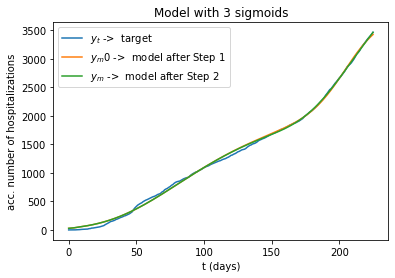

========= Wave nr 4 =========
From 0 to  303
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1019.7810060031101
     jac: array([-6.10351562e-05, -8.23974609e-04,  7.85827637e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 92
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([397.99789327, 258.82547601,  16.04996458,   1.        ])
Step 2
     fun: 954.6412157143125
     jac: array([ 9.15527344e-05, -4.57763672e-05, -1.10626221e-03,  7.11738510e+01])
 message: 'Optimization terminated successfully'
    nfev: 88
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([4.51434419e+02, 2.53699042e+02, 2.74916976e+01, 1.00000000e-01])


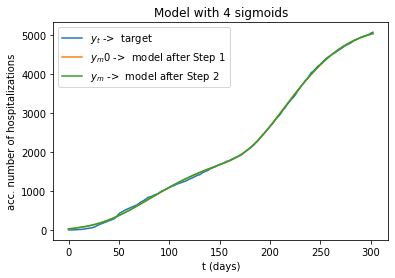

========= Wave nr 5 =========
From 0 to  375
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 971.6848822769069
     jac: array([5.34057617e-05, 1.37329102e-04, 1.75476074e-04, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 85
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([622.80762691, 329.17728399,  12.31858443,   1.        ])
Step 2
     fun: 850.0339066565325
     jac: array([-3.12805176e-04,  2.76947021e-03,  4.15802002e-03,  1.13455261e+02])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([6.81924621e+02, 3.24344255e+02, 2.03739506e+01, 1.00000000e-01])


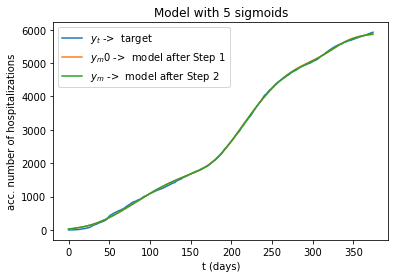

========= Wave nr 6 =========
From 0 to  431
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 768.9607458100969
     jac: array([ 2.28881836e-05,  1.26647949e-03, -3.46374512e-03,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 123
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([1.14110045e+03, 4.12401860e+02, 1.25687869e+01, 1.00000000e+00])
Step 2
     fun: 739.5014635130658
     jac: array([ 2.28881836e-05, -1.98364258e-04, -1.20544434e-03,  2.03233032e+01])
 message: 'Optimization terminated successfully'
    nfev: 173
     nit: 33
    njev: 33
  status: 0
 success: True
       x: array([1.79740967e+03, 4.18473374e+02, 2.93265691e+01, 1.00000000e-01])


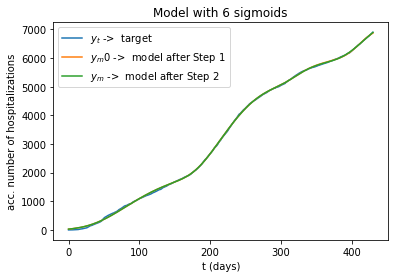

========= Wave nr 7 =========
From 0 to  590
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 998.8154999696827
     jac: array([-1.06811523e-04,  9.15527344e-05,  1.82342529e-03,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 109
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([1.77143310e+03, 4.96875738e+02, 2.18411324e+01, 1.00000000e+00])
Step 2
     fun: 714.1123671609361
     jac: array([ 3.05175781e-05,  5.41687012e-04, -1.98364258e-04,  1.91495819e+01])
 message: 'Optimization terminated successfully'
    nfev: 85
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.89530394e+03, 4.86914795e+02, 3.52963622e+01, 1.00000000e-01])


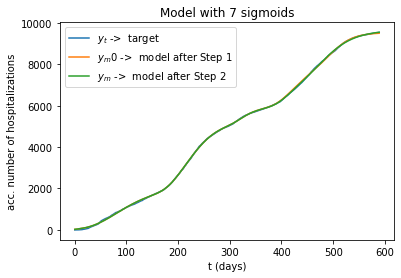

========= Wave nr 8 =========
From 0 to  657
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 648.9016391009229
     jac: array([6.10351562e-05, 1.67846680e-04, 5.34057617e-05, 0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 72
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([181.80300315, 612.21404273,   8.45511763,   1.        ])
Step 2
     fun: 644.2694605257126
     jac: array([-8.39233398e-05,  8.39233398e-04,  2.74658203e-04,  3.73896027e+00])
 message: 'Optimization terminated successfully'
    nfev: 76
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([1.91386899e+02, 6.07871582e+02, 1.35942269e+01, 1.00000000e-01])


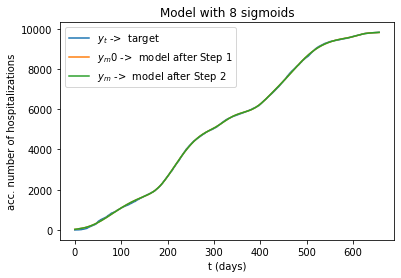

========= Wave nr 9 =========
From 0 to  775
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 654.0219265536523
     jac: array([-7.62939453e-06,  9.91821289e-04, -6.17980957e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 73
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([549.81094452, 689.5324103 ,  12.13981874,   1.        ])
Step 2
     fun: 591.2529822203771
     jac: array([ 1.29699707e-04, -1.37329102e-04, -6.86645508e-04,  5.56319504e+01])
 message: 'Optimization terminated successfully'
    nfev: 62
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([5.66097864e+02, 6.83334368e+02, 1.81317019e+01, 1.00000000e-01])


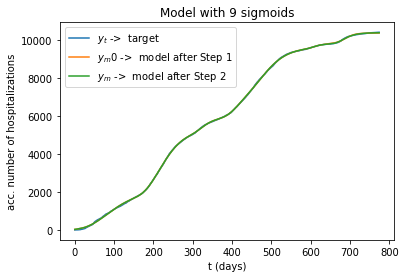

In [45]:
n_weeks_pred = 2
n_sig = 1
sig_params = []
for i in range(len(x_nw) + 1):
    if(i == len(x_nw)):
        n_days = len(acc_n_hosp) - 7*n_weeks_pred
    else:
        n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_n_hosp[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05
        #A0 *= 1.2
    # else:
    #     [A0, tp0, delta0, nu0] = sig_params[len(sig_params) - 1]
    #     tp0 = tp0 + 100
    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    y_t = acc_n_hosp[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"
    plt.title(f'Model with {n_sig} sigmoid{s}')
    plt.plot(y_t, label='$y_t$ ->  target')
    plt.plot(y_m0, label='$y_m0$ ->  model after Step 1')
    plt.plot(y_m, label='$y_m$ ->  model after Step 2')
    plt.xlabel('t (days)')
    plt.ylabel('acc. number of hospitalizations')
    plt.legend()
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

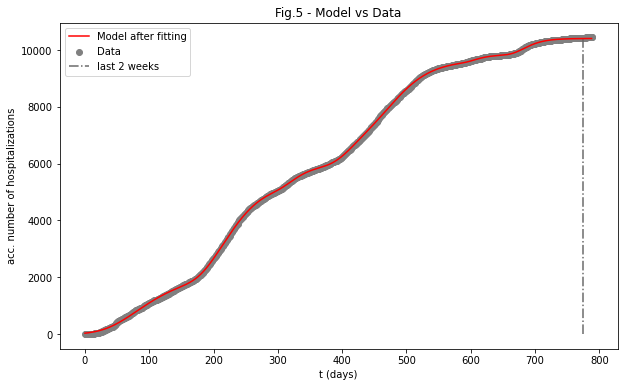

In [54]:
n_sig = 9
plt.figure(figsize=(10,6))
#plt.xlim(len(acc_n_hosp) - 7*n_weeks_pred, len(acc_n_hosp))
plt.title('Fig.5 - Model vs Data')
plt.scatter(t, acc_n_hosp, label='Data', c='gray')
plt.vlines(len(acc_n_hosp) - 7*n_weeks_pred, 0, max(acc_n_hosp), colors='dimgray', linestyles='dashdot', zorder=1, label=f"last {n_weeks_pred} weeks")
n_days = len(acc_n_hosp)
plt.plot(model(t, A, tp, delta, nu), label='Model after fitting', c='r')
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.legend()
plt.show()

In [61]:
n_days = len(acc_n_hosp) - 7*n_weeks_pred

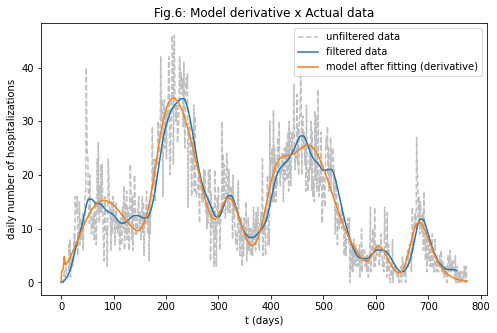

In [62]:
model_der = forward_euler(t[:n_days], 1, y_m[:n_days], 0)
daily_n_hosp = forward_euler(t[:n_days], 1, acc_n_hosp[:n_days], 0)

plt.figure(figsize=(8, 5))
plt.title('Fig.6: Model derivative x Actual data')
plt.plot(daily_n_hosp, label="unfiltered data", c='silver', linestyle='dashed')
plt.plot(filter_data(daily_n_hosp), label="filtered data")
plt.plot(model_der, label='model after fitting (derivative)')
plt.xlabel('t (days)')
plt.ylabel('daily number of hospitalizations')
plt.legend()
plt.show()

#### ===== Rascunho (testes para melhor entendimento) =====

In [ ]:
n_sig = 1
n_days = 90
# Initialize model parameters
A = 1500
tp = 20
delta = 3.1
nu = 2.2

y_t = acc_n_hosp[:n_days]
y_m = f_t(t[:n_days], A, tp, delta, nu)
plt.title('One Sigmoid (Single Wave)')
plt.plot(y_t, label='$y_t$ ->  target')
plt.plot(y_m, label='$y_m$ ->  model')
plt.plot(y_t - y_m, label='$y_t - y_m$')
plt.plot(abs(y_t - y_m), label='|$y_t - y_m$|')
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.legend()
plt.show()
plt.title('Squared Error')
plt.plot((y_t - y_m)**2, label='$(y_t - y_m)^2$')
plt.legend()
plt.show()
plt.title('Time Squared Error')
plt.plot(t[:n_days]*(y_t - y_m)**2, label='$t(y_t - y_m)^2$')
plt.xlabel('t (days)')
plt.ylabel('acc. number of hospitalizations')
plt.legend()
plt.show()


In [ ]:
# Fazendo testes com múltiplas ondas
# Modelo envolvendo soma de sigmoides assimétricas 
n_sig = 4
x = np.random.rand(4*n_sig)
x

In [ ]:
# Antigo... ignorar
n_sig = 4
# inicialização aleatória
x = np.random.rand(4*n_sig)
sigsum = np.zeros(n_days)
for i in range(n_sig):
    A = 1e2*x[i + 0]
    tp = 8*(i+1)
    delta = 2*x[i + 2]
    nu = 1
    sigsum += f_t(t[:n_days], A, tp, delta, nu)
plt.plot(sigsum)
plt.show()